# Ongoing exploration of p-value and confidence intervals from simulations.

In this notebook, I'm aiming to reproduce various bits of different published papers, and also some original hypothesis testing and exploratory simulations. The topic of meta-research is extremely interesting, and this notebook is a critical investigation into statistical tools and metrics that scientits use every day for decision-making purposes and evaluation of their results.

In [1]:
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
import scipy.stats as stats
from scipy.stats import norm


## Part 1. Generation of samples from simulated distributions. 

I'm aiming to generate random samples from different types of distribution, starting with gaussian one. This is because most of natural data is distributed normally, or (as you will see later on) approaches normality if sufficient large samples or number of samples are taken.

In [2]:
# This is the first method to generate a seed of 1000 values from a normal distribution with set parameters 
# The loop is iterating 1000 times and appending the random values with the random function/gauss method to an empty list

pop=[]
for i in range (1000):
    pop.append(random.gauss(0, 1))

# Here I make use of the numpy random.normal method to generate the same result

pop2 = np.random.normal(0.5, 1, 1000)
pop2 = list(pop2) #Here we have to transform the output of the np.random.normal method into a list, otherwise it won't be utilizable later on

### Plotting the data for visual proof

Here I needed the visual proof of normality. There are also statistical methods to assess a dataset for normality, but since we are talking about 1000 observation, visual proof will be more than enough.

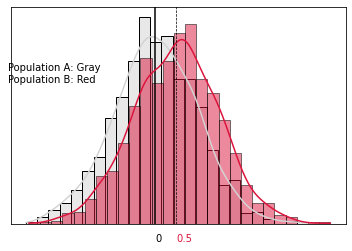

In [3]:
bins1 = sn.histplot(pop, color="lightgray", edgecolor="black", linewidth=1, kde=True)
plt.axvline(0,0,100,color="black")
bins1.axes.yaxis.set_visible(False)
bins1.axes.xaxis.set_visible(False)
plt.text(-3.5,80,'Population A: Gray\nPopulation B: Red',color="black")
plt.text(0,-10,'0',color="black")
plt.text(0.5,-10,'0.5',color="crimson")

bins2 = sn.histplot(pop2, color="crimson", edgecolor="black", linewidth=.5, kde=True)
plt.axvline(0.5,0,100,color="black", ls="dashed", lw=.7)

plt.savefig("popdistri.svg")

## Simulating 1000 t-test 

## Solution 1: Simulating 1000 t-tests

In [4]:
results = pd.DataFrame({'Effect Size':[], 'p-value':[]})
for i in range(10000):
    sample1 = np.random.normal(0,1,1000)
    sample2 = np.random.normal(.05,1,1000)
    effect_size, pvalue = stats.ttest_ind(a=sample1, b=sample2, equal_var=True)
    results.loc[i,:] = [effect_size,pvalue]

results

,Effect Size,p-value
0,-2.115852,0.034481
1,0.333983,0.738427
2,-0.417391,0.676437
3,-2.601519,0.009350
4,-2.052195,0.040281
...,...,...
9995,-1.217851,0.223424
9996,-0.381029,0.703222
9997,-1.309748,0.190432
9998,-0.531066,0.595432


## Main solution: defining the simulation_p function and the cohen_d function
    

    




In [5]:
from numpy import std, mean, sqrt
from scipy.stats import t

# This part of the code, defining the lists, is not needed anymore given that there's a function defined who does the job. Instead of repeating the loop over and over.
# results10 = []
# results30 = []
# results60 = []
# results100 = [] 


#Here I manually defined a function in order to calculate Cohen_d. This is preferred to the canonical effect size computation, which gives +oo results as it becomes more "precise"
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

# New version of the function simulation_p. With this function you get the effect size of a two sample t-test as Cohen's D
# You get the p-value associated with the ES and the log10 transformation of the p-values
# You also get the .95CI gap and the upper and lower bound for each paired samples test across the whole simulation.

def simulation_p (numerosity1,numerosity2,mean1,mean2,sd1,sd2,n1,n2):
    
    pop=[]
    pop2=[]
    for i in range (numerosity1):
        pop.append(random.gauss(mean1, sd1))
        pop2.append(random.gauss(mean2, sd2))
    
    dof1 = len(pop)-1
    dof2 = len(pop2)-1
    confidence = 0.95
    t_crit = np.abs(t.ppf((1-confidence)/2,dof1))
    results = pd.DataFrame({'Effect Size':[], 'p-value':[], '.95 Gap':[],'Upper Bound':[],'Lower Bound':[]})
    for i in range(numerosity2):
        sample1 = random.sample(pop, n1)
        sample2 = random.sample(pop2, n2)
        mean1 = np.mean(sample1)
        std1 = np.std(sample1)
        mean2 = np.mean(sample2)
        std2 = np.std(sample2)
        variance1 = np.square(std1)
        variance2 = np.square(std2)
        variance_pop = ((n1-1)*variance1+(n2-1)*variance2)/(n1+n2-2)
        standard_error = np.sqrt((variance_pop/n1)+(variance_pop/n2))
        effect_size, pvalue = stats.ttest_ind(b=sample1, a=sample2, equal_var=True)
        effect_size = cohen_d(sample2,sample1)
        upper_bound = np.absolute(mean1-mean2)+(t_crit*standard_error)
        lower_bound = np.absolute(mean1-mean2)-(t_crit*standard_error)
        gap = np.absolute(upper_bound-lower_bound)
        results.loc[i,:] = [effect_size,pvalue,gap,upper_bound,lower_bound]
    df = pd.DataFrame(results, columns=['Effect Size', 'p-value','.95 Gap','Upper Bound','Lower Bound'])
    df["log10"] = np.nan
    df["log10"] = np.log10(df["p-value"])

    return(df)

In [6]:
#Here instead we practically create 4 different dataframes with the simulation_p function

df10 = simulation_p(1000,1000,0,0.5,1,1,10,10)
df30 = simulation_p(1000,1000,0,0.5,1,1,30,30)
df60 = simulation_p(1000,1000,0,0.5,1,1,60,60)
df100 = simulation_p(1000,1000,0,0.5,1,1,100,100)


In [7]:
# Counting the number of p-values that are significative.

tensamples = df10['p-value'].to_list()
a = sum(i < .05 for i in tensamples)

thirsamples = df30['p-value'].to_list()
b = sum(i < .05 for i in thirsamples)

sixtsamples = df60['p-value'].to_list()
c = sum(i < .05 for i in sixtsamples)

hundrsamples = df100['p-value'].to_list()
d = sum(i < .05 for i in hundrsamples)

print(a,b,c,d)

224 428 762 977


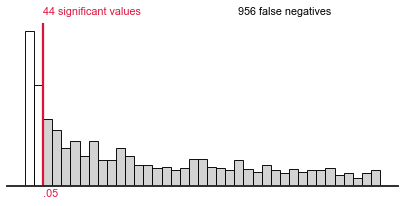

In [8]:
# plottling the same histogram with seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "figure.figsize":(7,3)}
sn.set_theme(context='talk', style='white', font='sans-serif', font_scale=.6, rc=custom_params)


plimit = 0.05

g = sn.histplot(x='p-value', data=df10, color="#FFF", edgecolor="black", bins=39)
plt.axvline(0.05, 0,1, color="Crimson")
plt.text(.05,150,'44 significant values', color="Crimson")
plt.text( .6,150,'956 false negatives', color="black")
plt.text(.05,-9.15,'.05',rotation=0, color="Crimson")
g.axes.yaxis.set_visible(False)
g.axes.xaxis.set_visible(False)

for rectangle in g.patches:
    if rectangle.get_x() >= plimit:
        rectangle.set_facecolor('LightGrey')
        


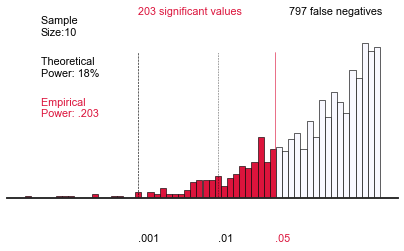

In [9]:
#plotting the same graph with sample size 10 but in a log10 scale

plimit = np.log10(.05)
plimit1 = np.log10(.01)
plimit2 = np.log10(.001)

g = sn.histplot(x='log10', data=df10, color="#FFF", edgecolor="black", bins=58)
plt.axvline(plimit, 0,.9, color="Crimson", lw=.6)
plt.axvline(plimit1, 0,.9, color="black", ls='dotted', lw=.6)
plt.axvline(plimit2, 0,.9, color="black", ls='dashed', lw=.6)
plt.text(-4.2,60,'Theoretical \nPower: 18%', color="black")
plt.text(-4.2,40,'Empirical \nPower: .203', color="Crimson")
plt.text(-4.2,80,'Sample \nSize:10', color="black")
plt.text(-3,90,'203 significant values', color="Crimson")
plt.text(-1.13,90,'797 false negatives', color="black")
plt.text(plimit,-21.2,'.05',rotation=0, color="Crimson")
plt.text(plimit1,-21.2,'.01',rotation=0, color="black")
plt.text(plimit2,-21.2,'.001',rotation=0, color="black")
g.axes.yaxis.set_visible(False)
g.axes.xaxis.set_visible(False)

for rectangle in g.patches:
    if rectangle.get_x() >= plimit:
        rectangle.set_facecolor('GhostWhite')

for rectangle in g.patches:
    if rectangle.get_x() <= plimit:
        rectangle.set_facecolor('Crimson')
        
plt.savefig("ttest10samples.svg")

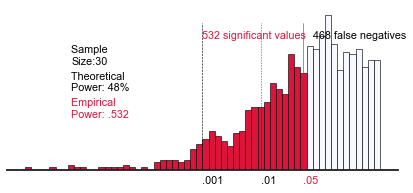

In [10]:
# Same Graph but for the 30 sample sizes

plimit = np.log10(.05)
plimit1 = np.log10(.01)
plimit2 = np.log10(.001)

g1 = sn.histplot(data=df30, x="log10", color="#FFF", edgecolor="black", bins=58)
plt.axvline(plimit, 0,.9, color="Crimson", lw=.6)
plt.axvline(plimit1, 0,.9, color="black", ls='dotted', lw=.6)
plt.axvline(plimit2, 0,.9, color="black", ls='dashed', lw=.6)
plt.text(-5.2,30,'Theoretical \nPower: 48%', color="black")
plt.text(-5.2,20,'Empirical \nPower: .532', color="Crimson")
plt.text(-5.2,40,'Sample \nSize:30', color="black")
plt.text(-3,50,'532 significant values', color="Crimson")
plt.text(-1.13,50,'468 false negatives', color="black")
plt.text(plimit,-5.2,'.05',rotation=0, color="Crimson")
plt.text(plimit1,-5.2,'.01',rotation=0, color="black")
plt.text(plimit2,-5.2,'.001',rotation=0, color="black")
g1.axes.yaxis.set_visible(False)
g1.axes.xaxis.set_visible(False)

for rectangle in g1.patches:
    if rectangle.get_x() >= plimit:
        rectangle.set_facecolor('GhostWhite')

for rectangle in g1.patches:
    if rectangle.get_x() <= plimit:
        rectangle.set_facecolor('Crimson')
        
plt.savefig("ttest30samples.svg")

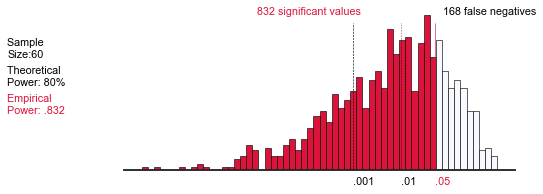

In [11]:
# Same Graph but for the 60 sample sizes

plimit = np.log10(.05)
plimit1 = np.log10(.01)
plimit2 = np.log10(.001)

g2 = sn.histplot(data=df60, x="log10", color="#FFF", edgecolor="black", bins=58)
plt.axvline(plimit, 0,.9, color="Crimson", lw=.6)
plt.axvline(plimit1, 0,.9, color="black", ls='dotted', lw=.6)
plt.axvline(plimit2, 0,.9, color="black", ls='dashed', lw=.6)
plt.text(-10.2,30,'Theoretical \nPower: 80%', color="black")
plt.text(-10.2,20,'Empirical \nPower: .832', color="Crimson")
plt.text(-10.2,40,'Sample \nSize:60', color="black")
plt.text(-5,55,'832 significant values', color="Crimson")
plt.text(-1.13,55,'168 false negatives', color="black")
plt.text(plimit,-5.2,'.05',rotation=0, color="Crimson")
plt.text(plimit1,-5.2,'.01',rotation=0, color="black")
plt.text(plimit2,-5.2,'.001',rotation=0, color="black")
g2.axes.yaxis.set_visible(False)
g2.axes.xaxis.set_visible(False)

for rectangle in g2.patches:
    if rectangle.get_x() >= plimit:
        rectangle.set_facecolor('GhostWhite')

for rectangle in g2.patches:
    if rectangle.get_x() <= plimit:
        rectangle.set_facecolor('Crimson')
        
plt.savefig("ttest60samples.svg")

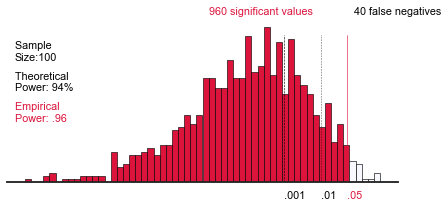

In [12]:
# Same Graph but for the 100 sample sizes

plimit = np.log10(.05)
plimit1 = np.log10(.01)
plimit2 = np.log10(.001)

g3 = sn.histplot(data=df100, x="log10", color="#FFF", edgecolor="black", bins=58)
plt.axvline(plimit, 0,.9, color="Crimson", lw=.6)
plt.axvline(plimit1, 0,.9, color="black", ls='dotted', lw=.6)
plt.axvline(plimit2, 0,.9, color="black", ls='dashed', lw=.6)
plt.text(-10.2,30,'Theoretical \nPower: 94%', color="black")
plt.text(-10.2,20,'Empirical \nPower: .96', color="Crimson")
plt.text(-10.2,40,'Sample \nSize:100', color="black")
plt.text(-5,55,'960 significant values', color="Crimson")
plt.text(-1.13,55,'40 false negatives', color="black")
plt.text(plimit,-5.2,'.05',rotation=0, color="Crimson")
plt.text(plimit1,-5.2,'.01',rotation=0, color="black")
plt.text(plimit2,-5.2,'.001',rotation=0, color="black")
g3.axes.yaxis.set_visible(False)
g3.axes.xaxis.set_visible(False)

for rectangle in g3.patches:
    if rectangle.get_x() >= plimit:
        rectangle.set_facecolor('GhostWhite')

for rectangle in g3.patches:
    if rectangle.get_x() <= plimit:
        rectangle.set_facecolor('Crimson')
        
plt.savefig("ttest100samples.svg")

In [13]:
#Calculating the 95% CI of the effect size distributions in the 4 different simulations (d10,d30,d60,d100)

ci10 = stats.norm.interval(0.95, loc= np.mean(df10['Effect Size']), scale= np.std(df10['Effect Size']))
ci30 = stats.norm.interval(0.95, loc= np.mean(df30['Effect Size']), scale= np.std(df30['Effect Size']))
ci60 = stats.norm.interval(0.95, loc= np.mean(df60['Effect Size']), scale= np.std(df60['Effect Size']))
ci100 = stats.norm.interval(0.95, loc= np.mean(df100['Effect Size']), scale= np.std(df100['Effect Size']))

print(ci10,ci30,ci60,ci100)

diff10 = ci10[0]-ci10[1]
diff30 = ci30[0]-ci30[1]
diff60 = ci60[0]-ci60[1]
diff100 = ci100[0]-ci100[1]

print(diff10,diff30,diff60,diff100)

(-0.3746674603481085, 1.507686819053752) (-0.03680018067714996, 0.9877578374430555) (0.14184378788180924, 0.8413758601941659) (0.279130056575853, 0.8148774480069398)
-1.8823542794018606 -1.0245580181202054 -0.6995320723123566 -0.5357473914310869


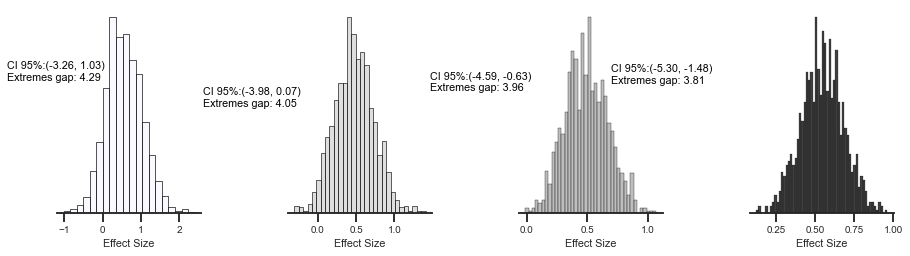

In [14]:
# Adjusting again the aesthetic paramethers of the seaborn theme to have a different result.
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sn.set_theme(context='talk', style='ticks', font='sans-serif', font_scale=.6, rc=custom_params)

intervals = plt.figure(figsize=[15,3.8])
intervals.subplots_adjust(hspace=0.4, wspace=.6)
#This is the first graph of the grid
ax = intervals.add_subplot(1,4,1)
sn.histplot(data=df10, x="Effect Size", color="GhostWhite", edgecolor="black", bins=20)
ax.axes.yaxis.set_visible(False)
plt.text(-2.5,100,'CI 95%:(-3.26, 1.03)\nExtremes gap: 4.29', color="black")
#This is the second graph of the grid
ax = intervals.add_subplot(1,4,2)
sn.histplot(data=df30, x="Effect Size", color="LightGray", edgecolor="black", lw=.6, bins=30)
ax.axes.yaxis.set_visible(False)
plt.text(-1.5,55,'CI 95%:(-3.98, 0.07)\nExtremes gap: 4.05', color="black")
#This is the third graph of the grid
ax = intervals.add_subplot(1,4,3)
sn.histplot(data=df60, x="Effect Size", color="DarkGray", edgecolor="black", bins=40)
ax.axes.yaxis.set_visible(False)
plt.text(-0.8,46,'CI 95%:(-4.59, -0.63)\nExtremes gap: 3.96', color="black")
#This is the fourth graph of the grid
ax = intervals.add_subplot(1,4,4)
sn.histplot(data=df100, x="Effect Size", color="Black", edgecolor="black", bins=58)
ax.axes.yaxis.set_visible(False)
plt.text(-0.8,35,'CI 95%:(-5.30, -1.48)\nExtremes gap: 3.81', color="black")

plt.savefig('CIgrid.svg')

In [15]:
#Just printing out some values that I need for the next graph.

log10_p = np.log10(0.05)
avg_gap10 = np.mean(df10['.95 Gap'])
avg_gap30 = np.mean(df30['.95 Gap'])
avg_gap60 = np.mean(df60['.95 Gap'])
avg_gap100 = np.mean(df100['.95 Gap'])

print(log10_p,avg_gap10,avg_gap30,avg_gap60,avg_gap100)

-1.3010299956639813 1.6546439339755696 0.9973658386672624 0.7187931414478833 0.5320417936073172


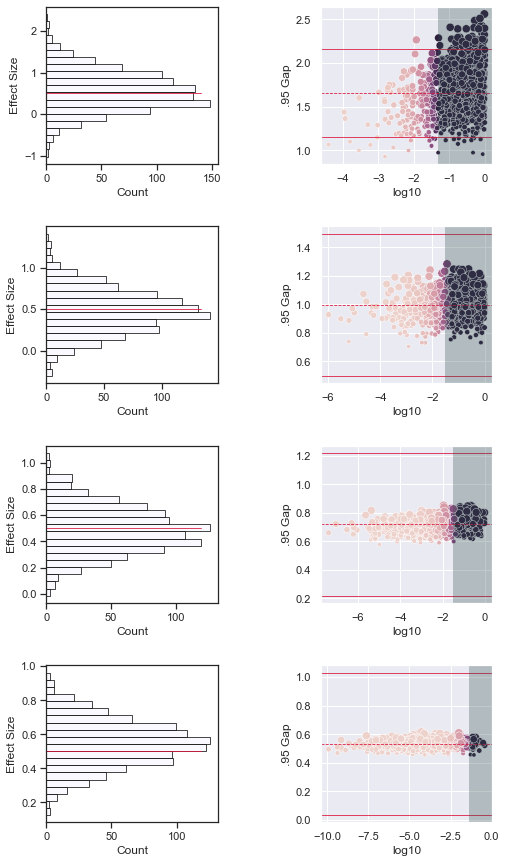

In [16]:
# Visualization of the distribution of p-values and effect sizes


density = plt.figure(figsize=[8,15])
density.subplots_adjust(hspace=0.4, wspace=.6)
#Graph number 1 histogram
sn.set_theme(style="ticks")
ay = density.add_subplot(4,2,1)
sn.histplot(data=df10, y="Effect Size", color="GhostWhite", edgecolor="black", bins=20)
plt.axhline(0.5, 0,.9, color="Crimson", lw=.8)
#Graph number 2 should be a density plot
sn.set_theme(style="darkgrid")
ay = density.add_subplot(4,2,2)
sn.scatterplot(data=df10, x="log10", y=".95 Gap", hue="p-value", size=".95 Gap", hue_norm=(0, 0.05), legend=False)
plt.axhline(avg_gap10, 0, 1, color="Crimson", lw=.8, ls="dashed")
plt.axhline((avg_gap10+0.5), 0, 1, color="Crimson", lw=.8)
plt.axhline((avg_gap10-0.5), 0, 1, color="Crimson", lw=.8)
plt.axvline(-0.55, 0, 1, color="DarkSlateGray", lw=55, alpha=.3)
#Graph number 3 should be a histogram
sn.set_theme(style="ticks")
ay = density.add_subplot(4,2,3)
sn.histplot(data=df30, y="Effect Size", color="GhostWhite", edgecolor="black", bins=20)
plt.axhline(0.5, 0,.9, color="Crimson", lw=.8)
#Graph number 4 should be a density plot
sn.set_theme(style="darkgrid")
ay = density.add_subplot(4,2,4)
sn.scatterplot(data=df30, x="log10", y=".95 Gap", hue="p-value", size=".95 Gap", hue_norm=(0, 0.05), legend=False)
plt.axhline(avg_gap30, 0, 1, color="Crimson", lw=.8, ls="dashed")
plt.axhline((avg_gap30+0.5), 0, 1, color="Crimson", lw=.8)
plt.axhline((avg_gap30-0.5), 0, 1, color="Crimson", lw=.8)
plt.axvline(-0.50, 0, 1, color="DarkSlateGray", lw=55, alpha=.3)
#Graph number 5 should be a histogram
sn.set_theme(style="ticks")
ay = density.add_subplot(4,2,5)
sn.histplot(data=df60, y="Effect Size", color="GhostWhite", edgecolor="black", bins=20)
plt.axhline(0.5, 0,.9, color="Crimson", lw=.8)
#Graph number 6 should be a density plot
sn.set_theme(style="darkgrid")
ay = density.add_subplot(4,2,6)
sn.scatterplot(data=df60, x="log10", y=".95 Gap", hue="p-value", size=".95 Gap", hue_norm=(0, 0.05), legend=False)
plt.axhline(avg_gap60, 0, 1, color="Crimson", lw=.8, ls="dashed")
plt.axhline((avg_gap60+0.5), 0, 1, color="Crimson", lw=.8)
plt.axhline((avg_gap60-0.5), 0, 1, color="Crimson", lw=.8)
plt.axvline(-0.45, 0, 1, color="DarkSlateGray", lw=45, alpha=.3)
#Graph number 7 should be a histogram
sn.set_theme(style="ticks")
ay = density.add_subplot(4,2,7)
sn.histplot(data=df100, y="Effect Size", color="GhostWhite", edgecolor="black", bins=20)
plt.axhline(0.5, 0,.9, color="Crimson", lw=.8)
#Graph number 8 should be a density plot
sn.set_theme(style="darkgrid")
ay = density.add_subplot(4,2,8)
sn.scatterplot(data=df100, x="log10", y=".95 Gap", hue="p-value", size=".95 Gap", hue_norm=(0, 0.05), legend=False)
plt.axhline(avg_gap100, 0, 1, color="Crimson", lw=.8, ls="dashed")
plt.axhline((avg_gap100+0.5), 0, 1, color="Crimson", lw=.8)
plt.axhline((avg_gap100-0.5), 0, 1, color="Crimson", lw=.8)
plt.axvline(-0.35, 0, 1, color="DarkSlateGray", lw=35, alpha=.3)


## Critique part: confidence intervals estimation with different sample sizes

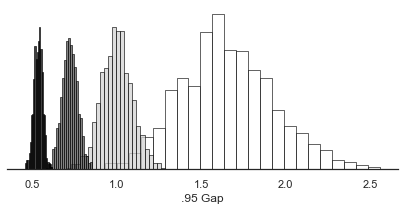

In [17]:
# Displaying the gap in the 95% CI at various sample sizes

sn.set_theme(style="white", rc=custom_params)
tr=sn.histplot(data=df10, x='.95 Gap', color="white", edgecolor="black", linewidth=.6)
sn.histplot(data=df30, x='.95 Gap', color="lightgray", edgecolor="black", linewidth=.6)
sn.histplot(data=df60, x='.95 Gap', color="#595959", edgecolor="black", linewidth=.6)
sn.histplot(data=df100, x='.95 Gap', color="black", edgecolor="black", linewidth=.6)
tr.axes.yaxis.set_visible(False)


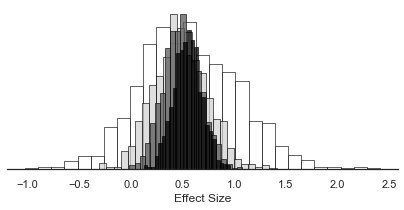

In [18]:
# Just a different way to display the narrowing of the confidence intervals. 
sn.set_theme(style="white", rc=custom_params)
tr=sn.histplot(data=df10, x='Effect Size', color="white", edgecolor="black", linewidth=.6)
sn.histplot(data=df30, x='Effect Size', color="lightgray", edgecolor="black", linewidth=.6)
sn.histplot(data=df60, x='Effect Size', color="#595959", edgecolor="black", linewidth=.6)
sn.histplot(data=df100, x='Effect Size', color="black", edgecolor="black", linewidth=.6)
tr.axes.yaxis.set_visible(False)

plt.savefig('centrality.svg')

### What if the underlying populations were, in fact, equal: probability density function

In [19]:
df30e = simulation_p(1000,1000,0,0,1,1,320,320)

In [20]:
# Defining a simple function for the histograms of the PDF

def histogram_distribution(input_data):
    plimit = np.log10(.05)
    plimit1 = np.log10(.01)
    plimit2 = np.log10(.001)
    g3 = sn.histplot(data=input_data, x="log10", color="#FFF", edgecolor="black", bins=58)
    plt.axvline(plimit, 0,.9, color="Crimson", lw=.6)
    plt.axvline(plimit1, 0,.9, color="black", ls='dotted', lw=.6)
    plt.axvline(plimit2, 0,.9, color="black", ls='dashed', lw=.6)
    plt.text(plimit,-5.2,'.05',rotation=0, color="Crimson")
    plt.text(plimit1,-5.2,'.01',rotation=0, color="black")
    plt.text(plimit2,-5.2,'.001',rotation=0, color="black")
    g3.axes.yaxis.set_visible(False)
    g3.axes.xaxis.set_visible(False)

    for rectangle in g3.patches:
        if rectangle.get_x() >= plimit:
            rectangle.set_facecolor('GhostWhite')

    for rectangle in g3.patches:
        if rectangle.get_x() <= plimit:
            rectangle.set_facecolor('Crimson')
    return(g3)

# Here instead I'm defining a function to count the number of signi

def counting_p(input_value):
    tensamples = input_value['p-value'].to_list()
    a = sum(i < .05 for i in tensamples)
    return(print(a))


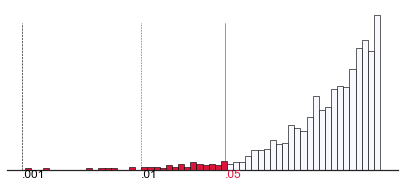

In [21]:
histo_equal = histogram_distribution(df30e)

In [22]:
counting_p(df30e)

49
